# TPV/TPC Data Processing

This notebook serves as a template for quickly processing TPV and TPC data. There is some customization that needs to be done to properly analyze each individual data set as each sample is unique and thus requires different parameters.

- Developed by Sangam Dhakal and Steven Carter, University of Toledo, 2023
- Developed for Python 3.11.3

### Load Packages and Define Functions

Be sure to adjust the necessary constants at the bottom of the first code block.

In [24]:
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.optimize import curve_fit
from scipy.signal import resample
import numpy as np
import os

#### Define Modelling Functions ####
def exp_fit(x, k1, k2, y0):
    return k1 * np.exp(k2 * x) + y0

def expGrow2(x, a, b, c, d, f):#x0
    return a * np.exp(b * x) + c * np.exp(d * x) + f

def exp1(t, A, tau, y0):#x0
    return A * np.exp(-t/tau) + y0

def exp2(t, A1, tao1, A2, tao2, y0, t0):
    return y0 + A1*np.exp(-(t+t0)/tao1)+ A2*np.exp(-(t+t0)/tao2)

def exp3(t, A1, tao1, A2, tao2, A3, tao3, y0, t0):
    return y0 + A1*np.exp(-(t+t0)/tao1)+ A2*np.exp(-(t+t0)/tao2) + A3*np.exp(-(t+t0)/tao3)

def linear_fit(x,k,y0):
    return k*x + y0

def exp_powerLaw(t, A, tau, k, c, t0):
    return A*np.exp(-(t+t0)/tau)+(1-A)*(t+t0)**(-k)+c

def powerLaw(x, A, alpha):
    return (A*((x)**alpha))

### End of Modelling Functions ###

### Shortcut Functions ###
def TPV_fitting(path: str, file_name: str, file_identifiers: list, Vocs: list, Voc_peaks: list, TPV_signals: list, Times_TPV: list, bounds_triple, bounds_double, bounds_single) -> tuple[list,list,list,list,list,list,list,list]:
    """
    This function does the calculations and fitting for the TPV data.
    You should not have to adjust anything in this function for each dataset.
    
    ### Inputs
    - path: Folder containing the data.
    - file_name: Name of the file (the loop variable).
    - file_identifiers: Empty list for the file identifiers.
    - Vocs: Empty list for the Voc values.
    - Voc_peaks: Empty list for the maximum Voc values.
    - TPV_signals: Empty list for the TPV signals.
    - Times_TPV: Empty list for the time axes.
    
    ### Returns
    - Fit1: Single exponential decay.
    - Fit2: Double exponential decay.
    - Fit3: Triple exponential decay.
    - popt1: Parameters for the single exponential decay fit.
    - popt2: Parameters for the double exponential decay fit.
    - popt3: Parameters for the triple exponential decay fit.
    """
    ### Cleaning Data, Find Voc ###
    # append the file name without the extension to the list of file names
    file_identifiers.append(file_name[:-4])
    
    raw_data = np.loadtxt(path + "\\" + file_name,delimiter=",", skiprows=1)
    raw_Signal = raw_data[:,1]

    # find the peak of the data
    index_of_peak = np.argmax(raw_Signal)
    
    # find Voc using the first 150 data points
    Voc = np.mean(raw_Signal[100:index_of_peak//2])
    Vocs.append(Voc)
    
    # subtract the Voc from the signal
    Signal = raw_Signal - Voc
    
    # find the maximum voltage reading
    Voc_max = np.max(Signal)
    Voc_peaks.append(Voc_max)
    
    TPV_signals.append(Signal)

    
    
    # adjust the time axis such that t=0 when Voltage at its maximum
    time = (raw_data[:,0] - raw_data[index_of_peak,0])
    Times_TPV.append(time)
    
    # take only the data beyond the peak
    t = time[index_of_peak:]
    S = Signal[index_of_peak:]
    
    # reduce the number of data points
    S, t = resample(S, int(len(S)/5), t)
    # chop off the lower end of the data. This is just noise.
    ival = S > 1e-5*max(S)
    S = S[ival] 
    t = t[ival]
    
    # normalize
    S_norm = S/max(S)
    
    # ignore the first 5 data points
    t = t[5:-5]
    S_norm = S_norm[5:-5]
    ### End of Data Cleaning ###
    
    ### Fitting ###
    # single exponential decay
    
    popt1, Fit1 = single_exp_fitting(t, S_norm, bounds_single)
    
    # double exponential decay
    
    popt2, Fit2 = double_exp_fitting(t, S_norm, popt1, bounds_double)
    
    # triple exponential decay
    
    popt3, Fit3 = triple_exp_fitting(t, S_norm, popt2, bounds_triple)

    return t, S_norm, Fit1, Fit2, Fit3, popt1, popt2, popt3

def TPC_fitting(path: str, file_name: str, file_identifiers: list, Jscs: list, Jsc_peaks: list, TPC_signals: list, Times_TPC: list, Qs: list, bounds_triple, bounds_double, bounds_single, bounds_expPowerLaw) -> tuple[list,list,list,list,list,list,list,list]:
    """
    This function does the calculations and fitting for the TPV data.
    You may need to adjust the `t0` and `t1` values to properly find `Q`.
    
    ### Inputs
    - path: Folder containing the data.
    - file_name: Name of the file (the loop variable).
    - file_identifiers: Empty list for the file identifiers.
    - Jscs: Empty list for the Jsc values.
    - Jsc_peaks: Empty list for the maximum Jsc values.
    - TPC_signals: Empty list for the TPC signals.
    - Times_TPC: Empty list for the time axes.
    - Qs: Empty list for the Q values.
    
    ### Returns
    - Fit1: Single exponential decay.
    - Fit2: Double exponential decay.
    - Fit3: Triple exponential decay.
    - FitPow: Decay for a single exponential with a power law.
    - popt1: Parameters for the single exponential decay fit.
    - popt2: Parameters for the double exponential decay fit.
    - popt3: Parameters for the triple exponential decay fit.
    - poptPow: Parameters for the single exponential with the power law.
    """
    
    file_identifiers.append(file_name[:-4])

    raw_data = np.loadtxt(path + "\\" + file_name,delimiter=",", skiprows=1)
    
    # convert voltage to current/area
    Signal = (raw_data[:,1])/(Rload*A2) # this is now A/cm^2
    
    # find the peak of the data
    index_of_peak = np.argmax(Signal)
    
    # find Voc using the first 150 data points
    Jsc = np.mean(Signal[100:index_of_peak//2])
    Jscs.append(Jsc)
    
    # subtract the Voc from the signal
    Signal = Signal - Jsc
    
    # find the maximum voltage reading
    Jsc_max = np.max(Signal)
    Jsc_peaks.append(Jsc_max)
    
    TPC_signals.append(Signal)

    
    time = (raw_data[:,0] - raw_data[index_of_peak,0])
    Times_TPC.append(time)
    
    t = time[index_of_peak:]
    S = Signal[index_of_peak:]
    
    # chop off the lower end of the data. This is just noise.
    ival = S > 1e-4*max(S)
    S = S[ival] 
    t = t[ival]
    
    # normalize
    S_norm = S/max(S)
    
    # ignore the high end because these values are influenced by the system response
    indexes = S_norm <= 0.3 * max(S_norm)
    t = t[indexes]
    S_norm = S_norm[indexes]
    
    # single exponential decay
    #popt1, Fit1 = single_exp_fitting(t, S_norm, bounds_single)
    
    # double exponential decay
    #popt2, Fit2 = double_exp_fitting(t, S_norm, popt1, bounds_double)
    
    # triple exponential decay
    #popt3, Fit3 = triple_exp_fitting(t, S_norm, popt2, bounds_triple)
    
    # power law decay
    #poptPow, FitPow = expPowerLaw_fitting(t, S_norm, bounds_expPowerLaw)
    
    # these values may need adjusted
    t0 = index_of_peak-50
    t1 = index_of_peak+6000
    
    if Jsc<0:
        t1 = index_of_peak+100
    
    # Uncomment this block to view how the calculation of Q is working.
    
    Q_t = integrate.cumtrapz(Signal[t0:t1],time[t0:t1],initial=0)
    plt.semilogy(time[t0:t1],Q_t)
    plt.show()
    
    
    # calculate Q
    Q: float = integrate.trapz(Signal[t0:t1],time[t0:t1])
    Qs.append(Q)
    
    return t, S_norm, None, None, None, None, None, None, None, None

def single_exp_fitting(x,y, bounds):
    try:
        popt1, pcov1 = curve_fit(exp1, x, y, bounds=bounds, maxfev=1000)
        Fit1 = exp1(x,*popt1)
        print('Single:')
        print(f'A: {popt1[0]:.3e}, tau: {popt1[1]:.3e}, y0: {popt1[2]:.3e}')
    except:
        popt1 = [np.nan] * 3
        Fit1 = None
        print("Not able to fit a single exponential decay.")
    
    return popt1, Fit1

def double_exp_fitting(x, y, popt1, bounds):
    try:
        # double exponential decay
        p0 = [popt1[0]*4/5, popt1[1]-0.05*popt1[1], popt1[0]*1/5, popt1[1]+0.05*popt1[1], popt1[2],0]
        #p0 = popt2
        popt2, pcov2 = curve_fit(exp2, x, y, bounds=bounds, maxfev=1000)
        Fit2 = exp2(x,*popt2)
        
        # re-order the parameters if needed. It should be that tau1<tau2.
        if popt2[1]>popt2[3]:
            # switches the position of tau1 and 2
            popt2[1], popt2[3] = popt2[3], popt2[1]
            # switches the position of A and B to be consistent
            popt2[0], popt2[2] = popt2[2], popt2[0]
            
        print('Double:')
        print(f'A: {popt2[0]:.3e}, tau1: {popt2[1]:.3e}')
        print(f'B: {popt2[2]:.3e}, tau2: {popt2[3]:.3e}')
        print(f'y0: {popt2[4]:.3e}, t0: {popt2[5]:.3e}')
    except:
        popt2 = [np.nan] * 5
        Fit2 = None
        print("Not able to fit a double exponential decay.")
        
    return popt2, Fit2

def triple_exp_fitting(x, y, popt2, bounds):
    try:
        # triple exponential decay
        p0 = [popt2[0]/2, popt2[1]-0.05*popt2[1], popt2[0]/2, popt2[1]+0.05*popt2[1], popt2[2], popt2[3], popt2[4], popt2[5]]
        #p0 = popt3
        popt3, pcov3 = curve_fit(exp3,x,y,bounds=bounds,maxfev=1000)
        Fit3 = exp3(x,*popt3)
        
        if popt3[1] > popt3[3]: # if a > b
            popt3[1], popt3[3] = popt3[3], popt3[1]
            popt3[0], popt3[2] = popt3[2], popt3[0]
        if popt3[1] > popt3[5]: # if a > c
            popt3[1], popt3[5] = popt3[5], popt3[1]
            popt3[0], popt3[4] = popt3[4], popt3[0] 
        if popt3[3] > popt3[5]: # if b > c
            popt3[3], popt3[5] = popt3[5], popt3[3]
            popt3[2], popt3[4] = popt3[4], popt3[3]
            
        print('Triple:')
        print(f'A: {popt3[0]:.3e}, tau1: {popt3[1]:.3e}')
        print(f'B: {popt3[2]:.3e}, tau2: {popt3[3]:.3e}')
        print(f'C: {popt3[4]:.3e}, tau3: {popt3[5]:.3e}')
        print(f'y0: {popt3[6]:.3e}, t0: {popt3[7]:.3e}')
       
    except:
        popt3 = [np.nan] * 7
        Fit3 = None
        print("Not able to fit a triple exponential decay.")
    
    return popt3, Fit3

def expPowerLaw_fitting(x,y,bounds):
    try:
        # single exponential with power law fit
        poptPow, pcovPow = curve_fit(exp_powerLaw, x, y, p0=[1, 2.23850709e-08, 9.74589945e-01, 6.51493914e-04,8.59024078e-09],bounds=bounds,maxfev=5000)
        FitPow = exp_powerLaw(x,*poptPow)
        print(f'Single Exp, Power Law: {poptPow}')
    except:
        poptPow = [np.nan] * 5
        FitPow = None
        print("Not able to fit a single exponential with a power law.")
        
    return poptPow, FitPow

def data_selection(x: np.ndarray, y: np.ndarray, left: float, right: float) -> tuple[np.ndarray, np.ndarray]:
    """
    This function selects the data between two points. This is repeatedly used when fitting only a portion of the data.
    
    ### Inputs
    - x: x-axis data
    - y: y-axis data
    - left: left end of data selection
    - right: right end of data selection
    
    ### Returns
    - x_sub: The subset of x-axis data between the left and right points.
    - y_sub: The corresponding subset of y-axis data between the left and right x-axis points.
    """
    
    x_sub = []
    y_sub = []
    
    for x_i,y_i in zip(x,y):
        if x_i < left: continue
        if x_i > right: break
        if x_i >= left and x_i <= right:
            x_sub.append(x_i)
            y_sub.append(y_i)
    
    return np.array(x_sub), np.array(y_sub)

def fit_bias_jsc(bias: np.array, jsc: np.array, left_edge: float, right_edge: float, plot_color: str) -> list:
    """
    This function is to shortcut the process of taking a subset of the data and fitting that section.
    
    ### Inputs
    - bias: A numpy array containing the bias values.
    - jsc: A numpy array containing the jsc values.
    - left_edge: The bias light intensity (in Amps) of the left edge of the fit section.
    - right_edge: The bias light intensity (in Amps) of the right edge of the fit section.
    - plot_color: The color of the line.
    
    ### Returns
    - popt: The parameters of the fit.
    """

    # Subset the data
    bias, jsc = data_selection(bias, jsc, left_edge, right_edge)
    
    # Fit the data
    popt, pcov = curve_fit(powerLaw, bias, jsc, check_finite=False)
    fit = powerLaw(bias,*popt)
    
    # Plot the fit
    plt.plot(bias,fit,color=plot_color)
    
    return popt

def fit_bias_voc(bias: np.array, voc: np.array, left_edge: float, right_edge: float, plot_color: str) -> tuple[list,float]:
    """
    This function is to shortcut the process of taking a subset of the data and fitting that section.
    
    ### Inputs
    - bias: A numpy array containing the bias values.
    - voc: A numpy array containing the voc values.
    - left_edge: The bias light intensity (in Amps) of the left edge of the fit section.
    - right_edge: The bias light intensity (in Amps) of the right edge of the fit section.
    - plot_color: The color of the line.
    """

    def func_voc(bias, n_id, E_a):
        return n_id * kB * T/q * np.log(bias) + E_a/q
    
    # Subset the data
    bias, voc = data_selection(bias, voc, left_edge, right_edge)
    
    # Fit the data
    params, pcov = curve_fit(func_voc, bias, voc)
    fit = func_voc(bias,*params)
    
    # Plot the fit
    plt.plot(bias,fit,color=plot_color)
    
    # calculate nid
    nid = params[0] #/(kB*T/q)
    
    return params, nid

def fit_jsc_voc(voc: np.ndarray, jsc: np.ndarray, left_edge: float, right_edge: float, plot_color: str) -> list:
    """
    This function fits and plots that fit for Jsc as a function of Voc.
    
    ### Inputs
    - voc: Voc values
    - jsc: Jsc values
    - left_edge: The Voc value corresponding to the left edge of the fit.
    - right_edge: The Voc value corresponding to the right edge of the fit.
    - plot_color: The color of the plot.
    
    ### Returns
    - popt: The parameters of the fit.
    """
    def fit_j(v,j0,n_id):
        return j0*(np.exp((q*v) / (n_id*kB*T))-1)
    
    voc_sub, jsc_sub = data_selection(voc, jsc, left_edge, right_edge)
    
    popt, pcov = curve_fit(fit_j, voc_sub, jsc_sub, p0=[1e-14,1.4], check_finite=False)
    fit = fit_j(voc_sub, *popt)
    
    plt.plot(voc_sub, fit, color=plot_color)
    
    return popt

def fit_capacitance(voc: np.ndarray, cap: np.ndarray, left_edge: float, right_edge: float, plot_color: str, bounds: tuple[list,list] = None) -> list:
    """
    This function fits the capacitance as a function of Voc. The fitting bounds can be stubborn.
    
    ### Inputs
    - voc: Array of Voc values
    - cap: Array of capacitance values
    - left_edge: Left edge of fitting range
    - right_edge: Right edge of fitting range
    - plot_color: Color of the plot.
    - bounds: Bounds for fitting. This is of the form ([...], [...])
    
    ### Returns
    - popt: The parameters of the fit.
    """
    def fit_cap_double(voc, A, m1, B, m2):
        return A*np.exp((q*voc)/(m1*kB*T)) + B*np.exp((q*voc)/(m2*kB*T))

    def fit_cap_double_c0(voc, A, m1, B, m2, c0):
        return A*np.exp((q*voc)/(m1*kB*T)) + B*np.exp((q*voc)/(m2*kB*T)) + c0
    
    def fit_cap_single(voc, A, k1, c0):
        return A*np.exp(k1*voc) + c0
    
    voc_sub, cap_sub = data_selection(voc, cap, left_edge, right_edge)
    
    if bounds is not None:
        popt, pcov = curve_fit(fit_cap_double, voc_sub, cap_sub, bounds=bounds, maxfev=10000, p0=[1.58e-16, 2.4e+01,2e-9, 5e+00])#, 2e-10])
    
        # insert Voc=0
        voc0 = np.insert(voc, 0, 0)
        
        fit  = fit_cap_double(voc0, *popt)
    else:
        popt, pcov = curve_fit(fit_cap_single, voc_sub, cap_sub, maxfev=10000)#, p0=[2e-11, 7.7e+00, 1.58e-16, 2.4e+01, 1.3e-09], maxfev=10000)
        # insert Voc=0
        voc0 = np.insert(voc, 0, 0)
        
        fit  = fit_cap_single(voc0, *popt)
    c0 = popt[-1]
    
    
    
    # plot the whole fit
    plt.plot(voc0, fit,                  color=plot_color)
    # plot just the linear part
    #plt.plot(voc0, [c0]*len(voc0), '--', color=plot_color)
    # plot just the exponential part
    #plt.plot(voc0, fit - c0,       '--', color=plot_color)
    
    return popt, c0, fit

def fit_tau_voc(vocs: np.ndarray, tau1: np.ndarray, left_edge: float, right_edge: float, plot_color: str) -> list:
        """
        This function fits and plots tau as a function of Voc.
        
        ### Inputs
        - vocs: Voc values.
        - tau1: tau1 values.
        - left_edge: The Voc value at which to start fitting.
        - right_edge: The Voc value at which to stop fitting.
        - plot_color: The color to use for the plot.
        
        ### Returns
        - popt: The fit parameters.
        """
        
        def fit_tau(voc,tau0,nu):
            return tau0*np.exp((-q*voc)/(nu*kB*T))
        
        # subset the data
        vocs_sub, tau1_sub = data_selection(vocs, tau1, left_edge, right_edge)
        
        # calculate the best fit
        popt, pcov = curve_fit(fit_tau, vocs_sub, tau1_sub, maxfev=10000)
        print(popt)
        # calculate the fit values
        fit = fit_tau(vocs_sub, *popt)
        
        # plot the fit
        plt.plot(vocs_sub, fit, color=plot_color)
        
        return popt

def fit_tau_n(n, tau, n0, left_edge, right_edge, plot_color) -> list:
    """
    This function fits tau as a function of n.
    
    ### Inputs
    - n: Charge density values.
    - tau: Lifetime values.
    - left_edge: Charge density for the left edge of the fit.
    - right_edge: Charge density for the right edge of the fit.
    - plot_color: Color of the plot.
    
    ### Returns
    - popt: Fitted parameters.

    """
    def fit_tau(n, tau0, m_nu):
        return tau0 * (n/n0)**(-m_nu)
    # subset the data
    n_sub, tau_sub = data_selection(n, tau, left_edge, right_edge)
    
    # calculate parameters
    popt, pcov = curve_fit(fit_tau, n_sub, tau_sub,maxfev=10000)#, bounds = ([1e-9, 1],[1,9]))
    
    # calculate fitted values
    fit = fit_tau(n_sub, *popt)

    # plot the fit
    plt.plot(n_sub,fit, color=plot_color)
    
    return popt

def calculate_n(c, voc, plot_label: str, plot_color: str, line_type: str = 'scatter'):
    """
    This function calculates and graphs the charge density.
    
    ### Inputs
    - c: Capacitance
    - voc: Voc
    - plot_label: Label for the plot.
    - plot_color: Color for the plot.
    - line_type: Type of line to plot. Default is `scatter`. Valid options are `scatter`, `line`, and  `dashed`.
    
    ### Returns
    - n: Charge density
    - line: Line of charge density for the legend.
    """
    
    n = integrate.cumulative_trapezoid(c,voc)/(q*(thickness_ETM+thickness_PVSK+thickness_HTM))
    
    # in the following, voc[1:] is used because the len(n)==len(voc)-1 due to the integration.
    if line_type == 'scatter':
        line = plt.scatter(voc[1:], n, label=plot_label, color=plot_color)
    elif line_type == 'line':
        line, = plt.plot(   voc[1:], n, ':', label=plot_label, color=plot_color)
    elif line_type == 'dashed':
        line, = plt.plot(   voc[1:], n, label=plot_label, color=plot_color, linestyle='dashed' )
    else:
        line, = plt.plot(   voc[1:], n, line_type,        label=plot_label, color=plot_color)
        
    return n, line

def fit_voc_n(voc, n, plot_color):
    def func_n(voc,n0,m): 
        return n0*np.exp((q*voc) / (m*kB*T))
    
    popt, pcov = curve_fit(func_n, voc, n,bounds=([0,0],[np.inf,np.inf]), check_finite=False,maxfev=10000)
    Fit = func_n(voc, *popt)
    plt.plot(voc, Fit, '--', color=plot_color)

    return popt

### End of Shortcut Functions ###

### Define Constants ###
thickness_ETM = 0 # active layer thickness in cm
thickness_PVSK = 0.9e-5#3.0e-4 # active layer thickness in cm
thickness_SP = 0.085e-4 # active layer thickness in cm
thickness_HTM = 0 # active layer thickness in cm
#thickness_ETM = 0
#thickness_HTM = 0
#thickness_SP = 0

Vbi = 1.041
q = 1.602e-19 # Coulombs
kB_eV = 8.6171e-5 # eV/K
kB = 1.3807e-23 # Joules/Kelvin
A2 = 0.1 # Area of the cell in cm^2
Rload = 50.0 # resistance in Ohms when doing TPC measurements
T = 298
### End of Constants ###

### Load and Fit the TPV measurements. 
1. Adjust the path variables to reflect the location of the data.
2. Adjust fit bounds, if needed.
3. Comment or Uncomment the plots to check the quality of the fits.

Single:
A: 9.317e-01, tau: 4.473e-06, y0: 2.775e-03
Double:
A: 5.977e-01, tau1: 3.550e-06
B: 3.629e-01, tau2: 5.974e-06
y0: 2.636e-03, t0: 4.918e-08
Not able to fit a triple exponential decay.


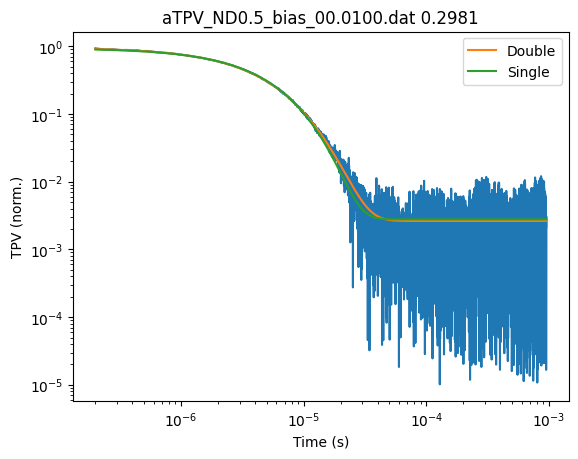

Single:
A: 9.354e-01, tau: 3.792e-06, y0: 2.564e-03
Double:
A: 3.348e-01, tau1: 2.483e-06
B: 6.498e-01, tau2: 4.411e-06
y0: 2.453e-03, t0: 1.015e-07
Triple:
A: 5.732e-01, tau1: 1.000e-07
B: 4.774e-01, tau2: 2.834e-06
C: 2.834e-06, tau3: 4.652e-06
y0: 2.448e-03, t0: 1.491e-07


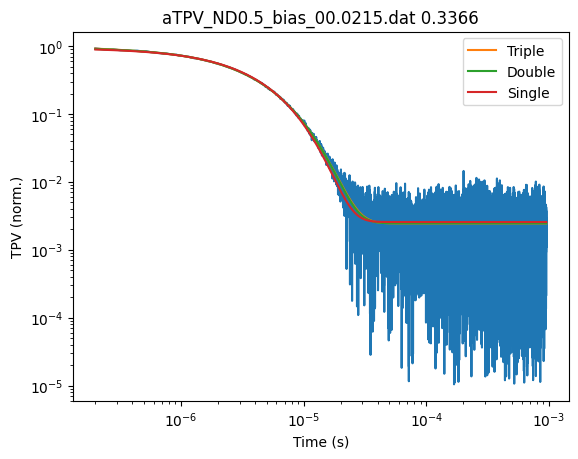

Single:
A: 9.333e-01, tau: 3.389e-06, y0: 2.223e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


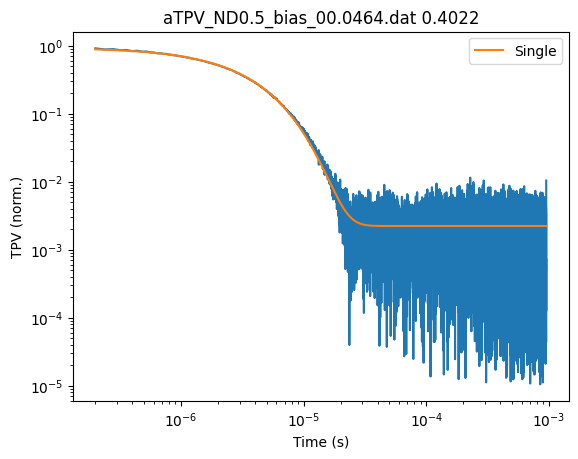

Single:
A: 9.247e-01, tau: 3.421e-06, y0: 1.823e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


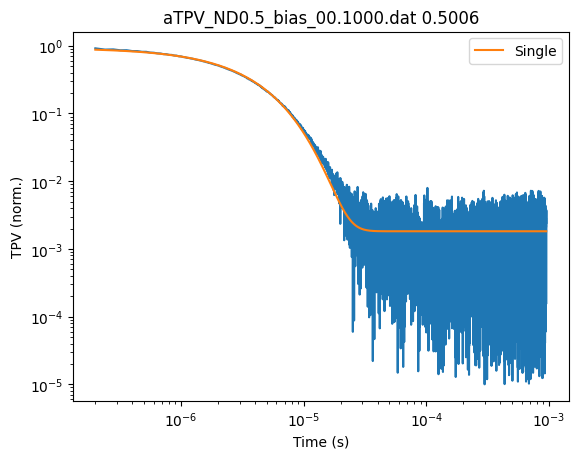

Single:
A: 9.084e-01, tau: 3.080e-06, y0: 1.277e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


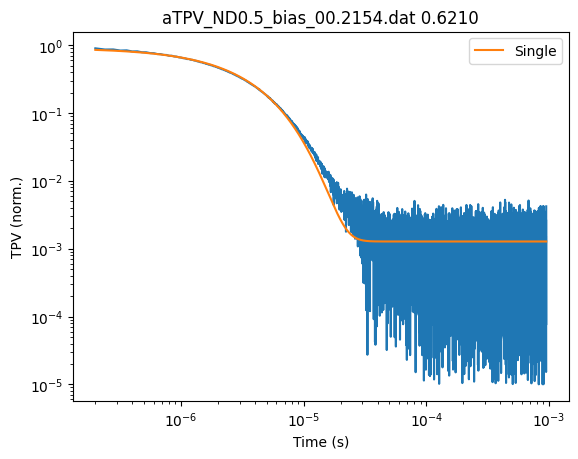

Single:
A: 9.264e-01, tau: 1.714e-06, y0: 1.383e-03
Double:
A: 4.969e-01, tau1: 1.072e-06
B: 6.577e-01, tau2: 2.092e-06
y0: 1.321e-03, t0: 2.705e-07
Not able to fit a triple exponential decay.


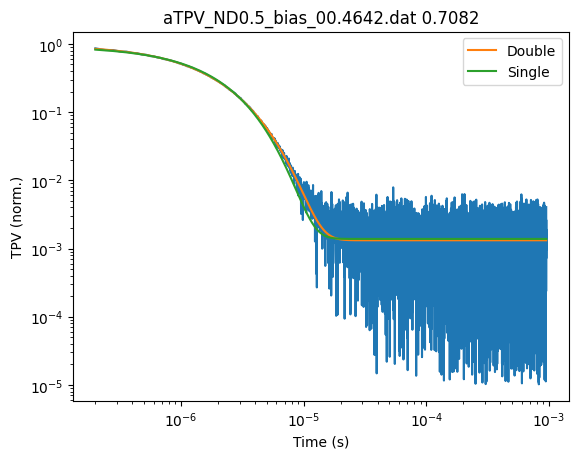

Single:
A: 9.309e-01, tau: 8.943e-07, y0: 9.872e-04
Double:
A: 4.269e-01, tau1: 5.999e-07
B: 5.499e-01, tau2: 1.087e-06
y0: 9.659e-04, t0: 4.615e-09
Not able to fit a triple exponential decay.


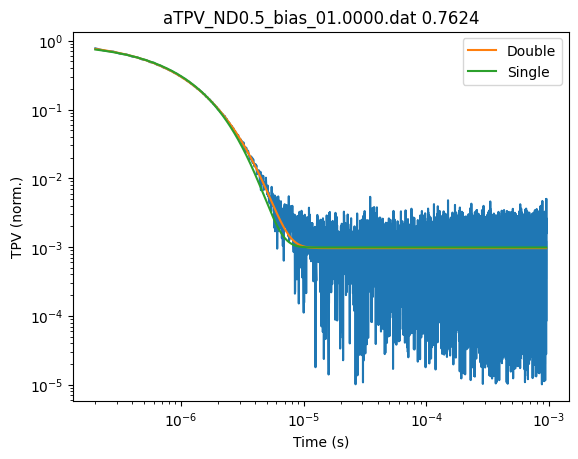

Single:
A: 9.689e-01, tau: 4.860e-07, y0: 1.008e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


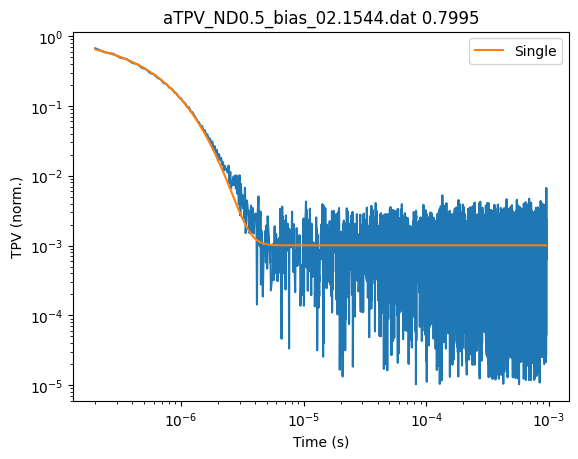

Single:
A: 1.026e+00, tau: 2.800e-07, y0: 1.184e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


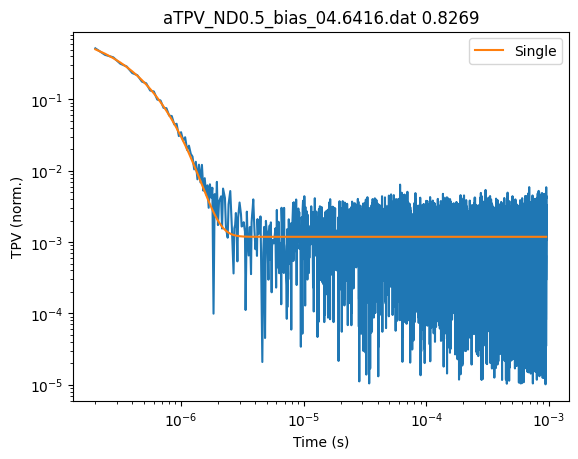

Single:
A: 1.160e+00, tau: 1.729e-07, y0: 1.855e-03
Not able to fit a double exponential decay.
Not able to fit a triple exponential decay.


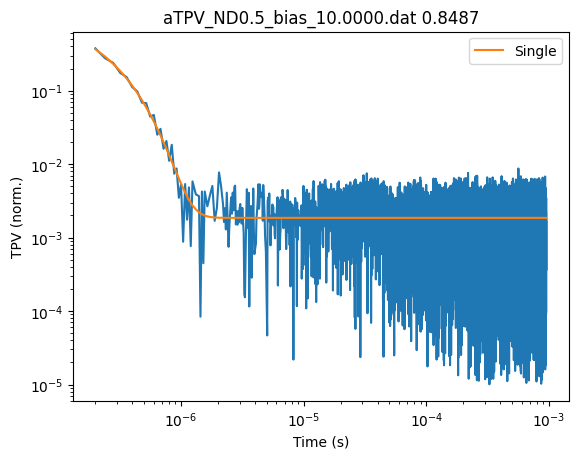

In [25]:
# # Path to TPV data
# path_TPV_controlled   = r'C:\Users\sngmd\Documents\DataAnalysis\20230722_CuDoped_CdTe\Controlled\TPV'

# # load the TPV data
# file_names_controlled   = os.listdir(path_TPV_controlled  )

# # lists for Voc, max(V), TPV signals, and the time axes
# Vocs_controlled   = []
# Voc_maximums_controlled   = []
# TPV_controlled_signals    = []
# Times_TPV_controlled      = []
# file_identifiers_TPV_controlled   = []
# params_TPV_single_controlled   = []
# params_TPV_double_controlled   = []
# params_TPV_triple_controlled   = []

# ### Fitting Bounds ###
# ### Adjust these to refine the fit. They are of the form [lower, upper].
# A    = [1e-3,2] 
# tau1 = [1e-7,1e-2]
# B    = [1e-3,2]
# tau2 = [1e-7,1e-2]
# C    = [1e-3,2]
# tau3 = [1e-7,1e-2]
# y0   = [0,1e-2] # vertical offset
# t0   = [0,1e-5] # horizontal offset

# # converts the bounds into the appropriate data structure to be input into scipy.optimize.curve_fit()
# bounds_single = tuple([[A[i],tau1[i],                          y0[i]      ] for i in [0,1]])
# bounds_double = tuple([[A[i],tau2[i],B[i],tau2[i],             y0[i],t0[i]] for i in [0,1]])
# bounds_triple = tuple([[A[i],tau2[i],B[i],tau2[i],C[i],tau3[i],y0[i],t0[i]] for i in [0,1]])

# ### Finding TPV Fits ###

# for file_name in file_names_controlled:
#     if not file_name.endswith(".dat"): continue
    
#     t, S_norm, Fit1, Fit2, Fit3, popt1, popt2, popt3 = TPV_fitting(path_TPV_controlled, file_name, file_identifiers_TPV_controlled, Vocs_controlled,
#                                                         Voc_maximums_controlled, TPV_controlled_signals, Times_TPV_controlled,
#                                                         bounds_triple, bounds_double, bounds_single)#, popt1, popt2, popt3)
    
#     params_TPV_single_controlled.append(popt1)
#     params_TPV_double_controlled.append(popt2)
#     params_TPV_triple_controlled.append(popt3)

#     # Uncomment this block if you want to view the fits
    
#     plt.loglog(t,S_norm) # normalized data
#     if Fit3 is not None: plt.loglog(t,Fit3,label="Triple") # triple exp decay fit
#     if Fit2 is not None: plt.loglog(t,Fit2,label="Double") # double exp decay fit
#     if Fit1 is not None: plt.loglog(t,Fit1,label="Single") # single exp decay fit
    
#     plt.title(f'{file_name} {Vocs_controlled[-1]:.4f}')
#     plt.xlabel("Time (s)")
#     plt.ylabel("TPV (norm.)")
#     plt.legend()
#     plt.show()
        
# Path to TPV data
path_TPV_controlled = r'C:\Users\sngmd\OneDrive\Desktop\Research\TPV'

# Load the TPV data
file_names_controlled = os.listdir(path_TPV_controlled)

# Lists for various data
Vocs_controlled, Voc_maximums_controlled, TPV_controlled_signals = [], [], []
Times_TPV_controlled, file_identifiers_TPV_controlled = [], []
params_TPV_single_controlled, params_TPV_double_controlled, params_TPV_triple_controlled = [], [], []

# Fitting Bounds - Adjust these to refine the fit.
bounds = {
    'A': [1e-3, 2],
    'tau1': [1e-7, 1e-2],
    'B': [1e-3, 2],
    'tau2': [1e-7, 1e-2],
    'C': [1e-3, 2],
    'tau3': [1e-7, 1e-2],
    'y0': [0, 1e-2],  # vertical offset
    't0': [0, 1e-5]   # horizontal offset
}

# Convert the bounds into the structure for scipy.optimize.curve_fit()
bounds_single = tuple([[bounds['A'][i], bounds['tau1'][i], bounds['y0'][i]] for i in [0, 1]])
bounds_double = tuple([[bounds['A'][i], bounds['tau2'][i], bounds['B'][i], bounds['tau2'][i], bounds['y0'][i], bounds['t0'][i]] for i in [0, 1]])
bounds_triple = tuple([[bounds['A'][i], bounds['tau2'][i], bounds['B'][i], bounds['tau2'][i], bounds['C'][i], bounds['tau3'][i], bounds['y0'][i], bounds['t0'][i]] for i in [0, 1]])

# Process and plot TPV Fits
for file_name in file_names_controlled:
    if not file_name.endswith(".dat"):
        continue

    t, S_norm, Fit1, Fit2, Fit3, popt1, popt2, popt3 = TPV_fitting(
        path_TPV_controlled, file_name, file_identifiers_TPV_controlled, Vocs_controlled,
        Voc_maximums_controlled, TPV_controlled_signals, Times_TPV_controlled,
        bounds_triple, bounds_double, bounds_single
    )

    params_TPV_single_controlled.extend([popt1])
    params_TPV_double_controlled.extend([popt2])
    params_TPV_triple_controlled.extend([popt3])

    # Plot results
    plt.loglog(t, S_norm)  # normalized data
    
    if Fit3 is not None and Fit3.any():
        plt.loglog(t, Fit3, label="Triple")  # triple exp decay fit
    
    if Fit2 is not None and Fit2.any():
        plt.loglog(t, Fit2, label="Double")  # double exp decay fit
    
    if Fit1 is not None and Fit1.any():
        plt.loglog(t, Fit1, label="Single")  # single exp decay fit
    
    plt.title(f'{file_name} {Vocs_controlled[-1]:.4f}')
    plt.xlabel("Time (s)")
    plt.ylabel("TPV (norm.)")
    plt.legend()
    plt.show()


#### Choose how many exponentials are needed for each of the bias light intensities.
This makes the plotting later on cleaner. You will need to adjust the number of points to reflect the best way to model the TPV decays.

In [26]:
# how many bias light intensities are best fitted by single, double, or triple exponential fits?
number_triples_controlled = 0
number_doubles_controlled = 0
number_singles_controlled = 30
# these should add up to the total number of measurements

# make a single pandas dataframe with all of the proper parameters.
params_TPV_controlled        = pd.DataFrame(columns=["A","tau1","B","tau2","C","tau3","y0","t0"])
params_TPV_triple_controlled = pd.DataFrame(params_TPV_triple_controlled, columns=["A","tau1","B","tau2","C","tau3","y0","t0"])
params_TPV_double_controlled = pd.DataFrame(params_TPV_double_controlled, columns=["A","tau1","B","tau2","y0","t0"])
params_TPV_single_controlled = pd.DataFrame(params_TPV_single_controlled, columns=["A","tau1","y0"])

triple_slice = params_TPV_triple_controlled.iloc[:number_triples_controlled,:]
double_slice = params_TPV_double_controlled.iloc[number_triples_controlled:number_triples_controlled+number_doubles_controlled,:]
if number_singles_controlled > 0:
    single_slice = params_TPV_single_controlled.iloc[-number_singles_controlled:,:]
else: single_slice = pd.DataFrame()

params_TPV_controlled = pd.concat([triple_slice, double_slice, single_slice])
params_TPV_controlled.interpolate(limit_area='inside',inplace=True)

print(params_TPV_controlled.to_string())

tau1_TPV_controlled   = params_TPV_controlled[  'tau1']
A_TPV_controlled      = params_TPV_controlled[  'A']
tau2_TPV_controlled   = params_TPV_controlled[  'tau2']
B_TPV_controlled      = params_TPV_controlled[  'B']
tau3_TPV_controlled   = params_TPV_controlled[  'tau3']
C_TPV_controlled      = params_TPV_controlled[  'C']

          A          tau1   B  tau2   C  tau3        y0  t0
0  0.931651  4.473484e-06 NaN   NaN NaN   NaN  0.002775 NaN
1  0.935426  3.791635e-06 NaN   NaN NaN   NaN  0.002564 NaN
2  0.933307  3.389298e-06 NaN   NaN NaN   NaN  0.002223 NaN
3  0.924729  3.420768e-06 NaN   NaN NaN   NaN  0.001823 NaN
4  0.908411  3.079710e-06 NaN   NaN NaN   NaN  0.001277 NaN
5  0.926445  1.713871e-06 NaN   NaN NaN   NaN  0.001383 NaN
6  0.930862  8.943089e-07 NaN   NaN NaN   NaN  0.000987 NaN
7  0.968906  4.860206e-07 NaN   NaN NaN   NaN  0.001008 NaN
8  1.026187  2.799512e-07 NaN   NaN NaN   NaN  0.001184 NaN
9  1.159729  1.729492e-07 NaN   NaN NaN   NaN  0.001855 NaN


### Load, Fit the TPC measurements, and find Total Charge, $Q$.
1. Adjust the path variables to reflect the location of the data.
2. Adjust the fitting bounds, if needed.
3. Comment or Uncomment the plots to check the fits and calculation of $Q$.
    - You may need to adjust the `t0` and `t1` values for calculating $Q$.

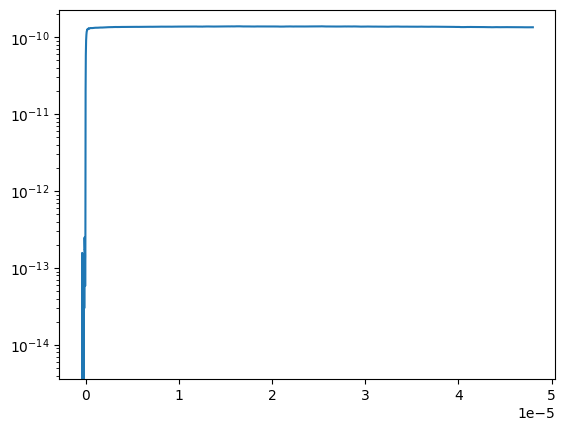

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


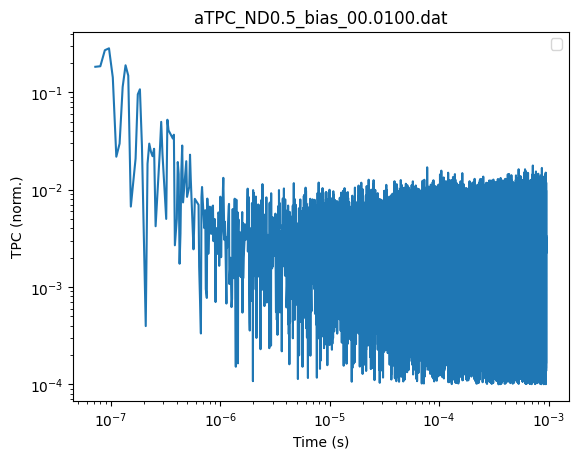

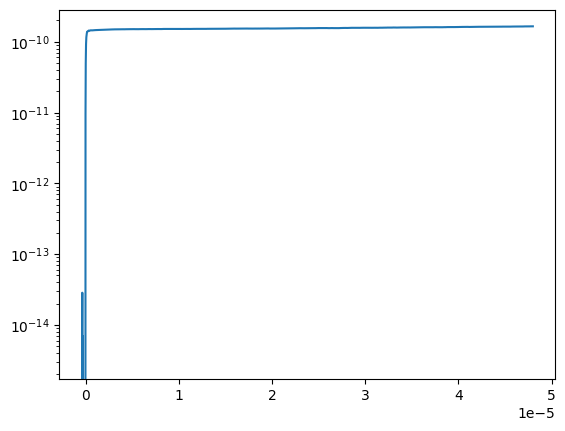

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


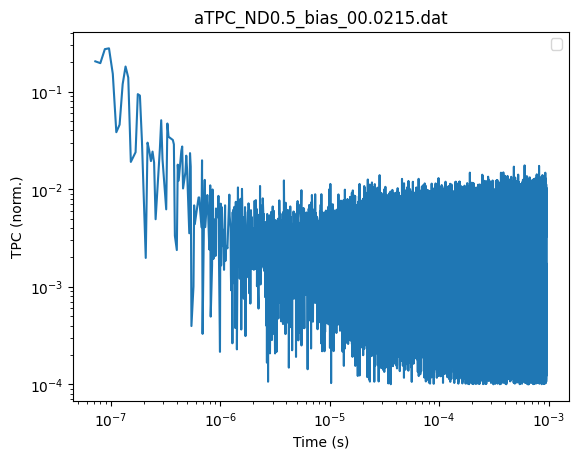

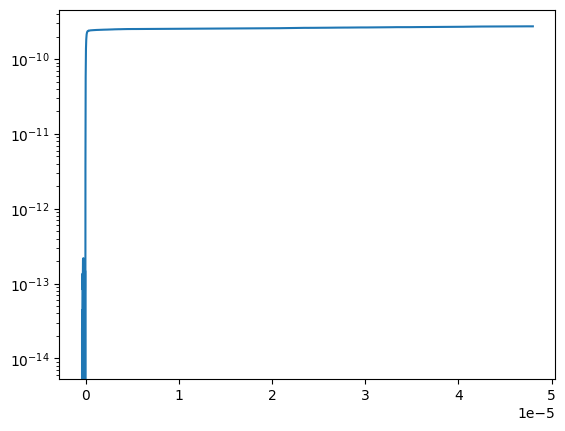

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


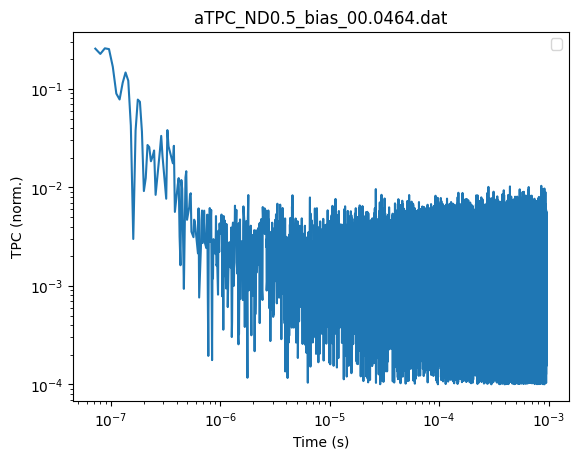

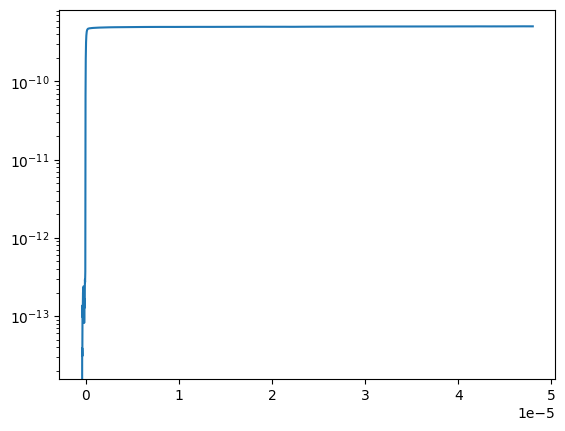

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


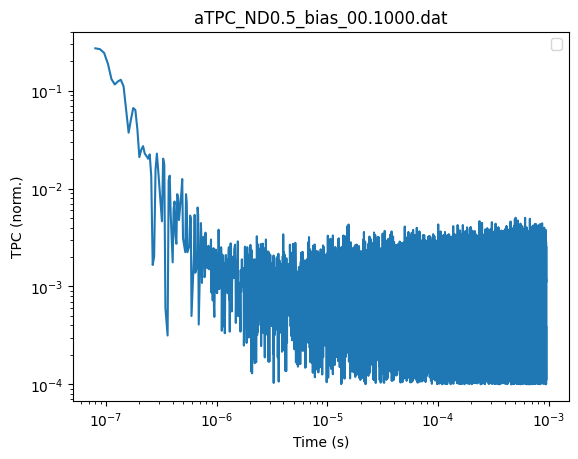

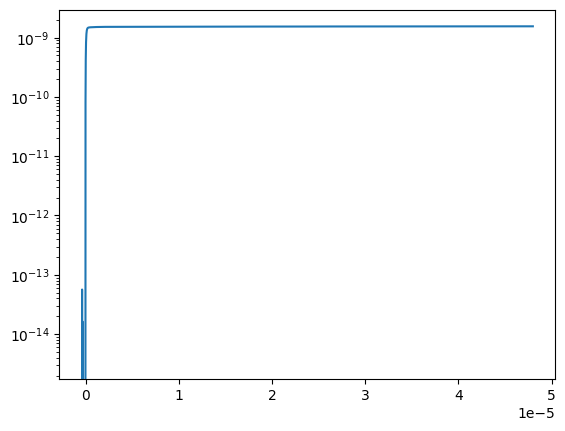

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


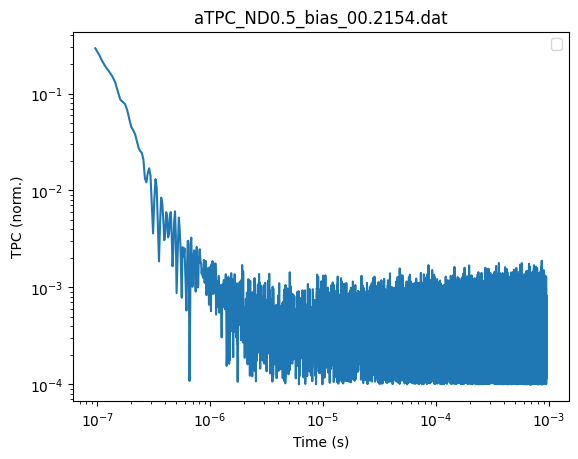

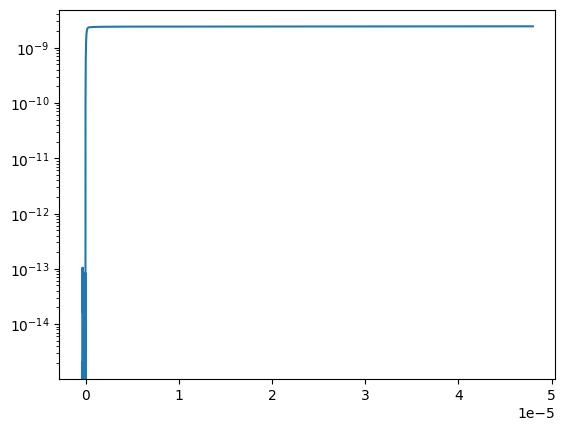

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


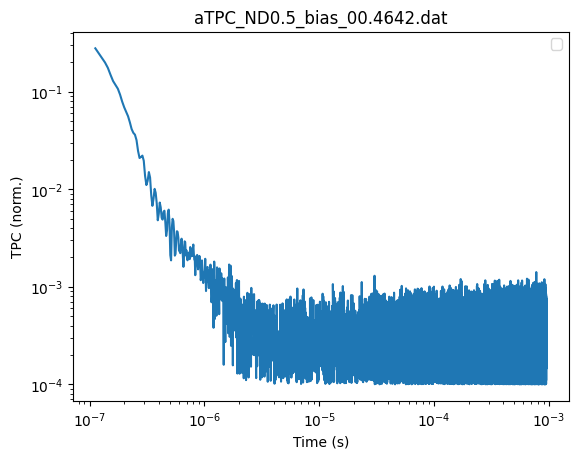

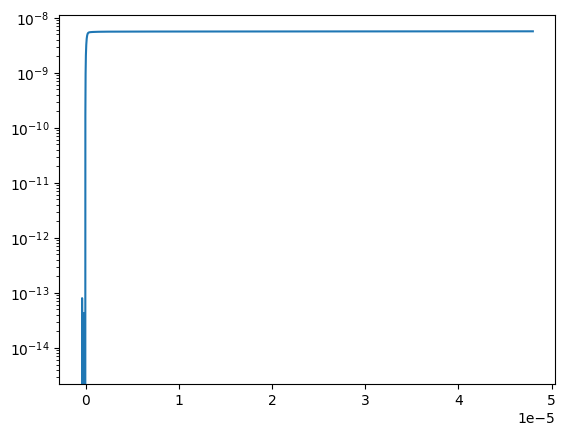

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


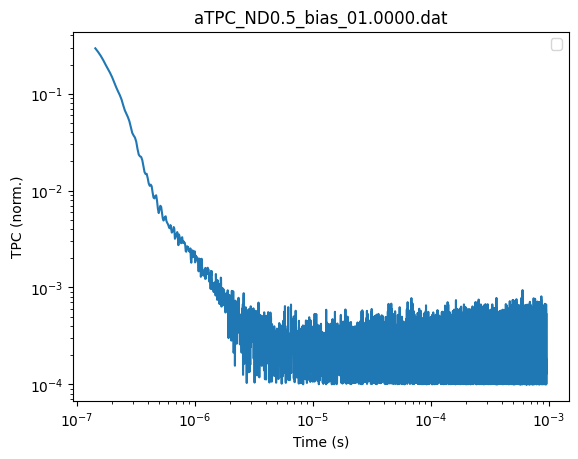

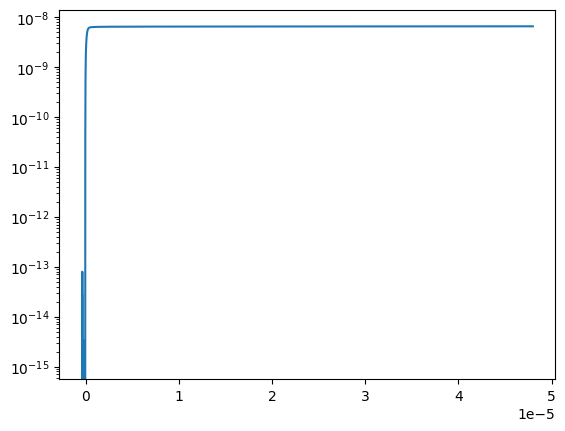

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


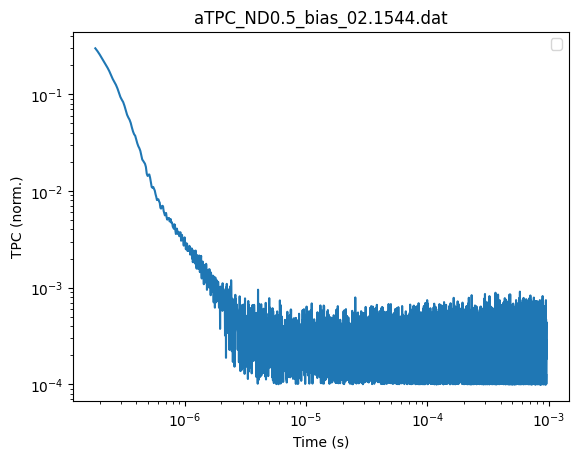

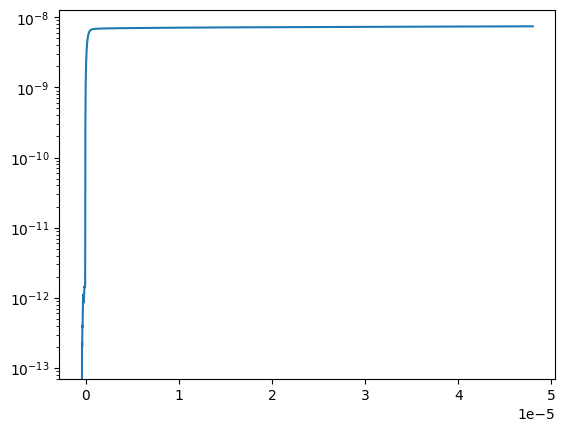

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


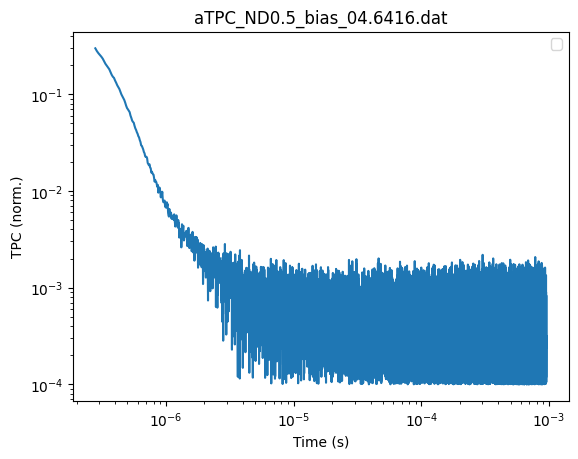

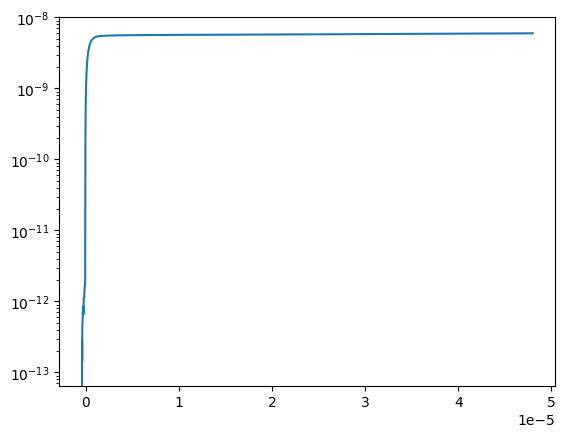

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


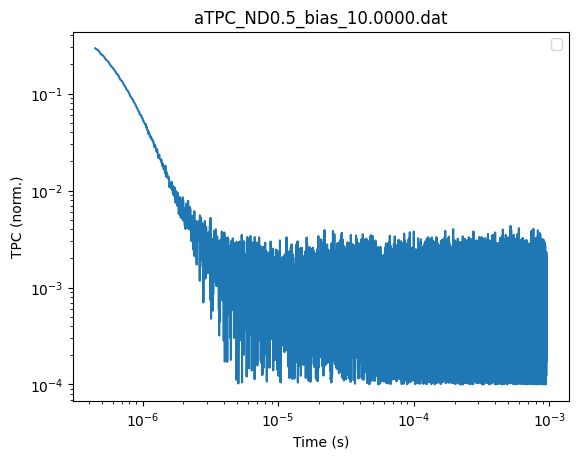

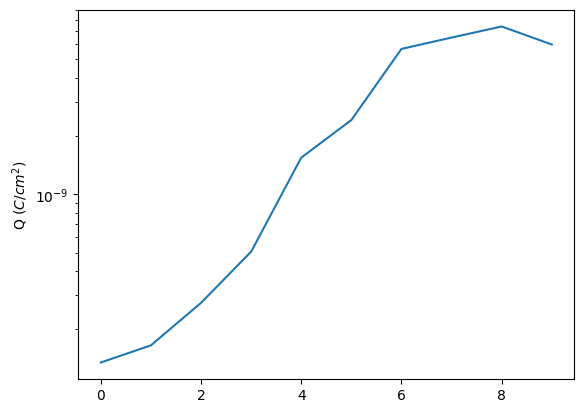

In [27]:
# Path to TPC data
path_TPC_controlled   = r'C:\Users\sngmd\OneDrive\Desktop\Research\TPC'

# load the TPC data
file_names_controlled   = os.listdir(path_TPC_controlled)

# lists for Jsc, max(V), TPC signals, and the time axes
Jscs_controlled         = []
Jsc_maximums_controlled = []
TPC_controlled_signals  = []
Times_TPC_controlled    = []
Qs_controlled           = []
params_TPC_single_controlled = []
params_TPC_double_controlled = []
params_TPC_triple_controlled = []
params_TPC_exppow_controlled = []
file_identifiers_TPC_controlled = []

### Fitting Bounds ###
### Adjust these to refine the fit. They are of the form [lower, upper].
A    = [0.001,2] 
tau1 = [1e-9,1e-4]
B    = [0.001,2]
tau2 = [1e-9,1e-3]
C    = [0.001,2]
tau3 = [1e-9,1e-1]
y0   = [0,1] # vertical offset
t0   = [-1e-5,1e-6] # horizontal offset

Ap = [0,1]
taup = [0,10]
kp = [0,2]
cp = [0,0.1] # vertical offset
tp = [0,1] # horizontal offset

# converts the bounds into the appropriate data structure to be input into scipy.optimize.curve_fit()
bounds_single      = tuple([[A[i], tau1[i],                          y0[i]      ] for i in [0,1]])
bounds_double      = tuple([[A[i], tau1[i],B[i],tau2[i],             y0[i],t0[i]] for i in [0,1]])
bounds_triple      = tuple([[A[i], tau1[i],B[i],tau2[i],C[i],tau3[i],y0[i],t0[i]] for i in [0,1]])
bounds_expPowerLaw = tuple([[Ap[i],taup[i],kp[i],                    cp[i],tp[i]] for i in [0,1]])

### Figure 2: TPC Fit ###
for file_name in file_names_controlled:
    if file_name.endswith(".dat"):
        
        t, S_norm, Fit1, Fit2, Fit3, FitPow, popt1, popt2, popt3, poptPow = TPC_fitting(path_TPC_controlled, file_name, file_identifiers_TPC_controlled,
                                                                                        Jscs_controlled, Jsc_maximums_controlled, TPC_controlled_signals,
                                                                                        Times_TPC_controlled, Qs_controlled, bounds_triple,
                                                                                        bounds_double, bounds_single, bounds_expPowerLaw)
        '''
        params_TPC_single_controlled.append(popt1)
        params_TPC_double_controlled.append(popt2)
        params_TPC_triple_controlled.append(popt3)
        params_TPC_exppow_controlled.append(poptPow)
        '''
        # Uncomment this block to check the fits.
        
        plt.loglog(t,S_norm) # normalized data
        #if Fit1   is not None: plt.semilogy(t,Fit1,label="Single") # single exponential decay fit
        #if Fit2   is not None: plt.semilogy(t,Fit2,label="Double") # double exponential decay fit
        #if Fit3   is not None: plt.semilogy(t,Fit3,label="Triple") # triple exponential decay fit
        #if FitPow is not None: plt.loglog(t,FitPow,label="Exp + PowerLaw") # single exponential with power law fit
        
        plt.title(file_name)
        plt.xlabel("Time (s)")
        plt.ylabel("TPC (norm.)")
        plt.legend()
        plt.show()
        
# Uncomment this block to check the calculation of Q.
plt.semilogy(Qs_controlled)
plt.ylabel("Q ($C/cm^2$)")
plt.show()

#### Convert the lists to lists of lists containing the data to Pandas DataFrames.

In [28]:
TPV_controlled_full  = pd.DataFrame(TPV_controlled_signals).transpose()
TPV_controlled_times = pd.DataFrame(Times_TPV_controlled  ).transpose()
TPV_controlled_full.columns  = file_identifiers_TPV_controlled
TPV_controlled_times.columns = file_identifiers_TPV_controlled

TPC_controlled_full  = pd.DataFrame(TPC_controlled_signals).transpose()
TPC_controlled_times = pd.DataFrame(Times_TPC_controlled  ).transpose()
TPC_controlled_full.columns  = file_identifiers_TPC_controlled
TPC_controlled_times.columns = file_identifiers_TPC_controlled

#### Pull the bias light intensities from the column names.
This is assuming all files were named with a regular pattern. This is set up for the form of `aTPV_ND0.5_bias_xx.xxxx.dat`, where `xx.xxxx` represents the bias light intensity in Amps.

In [29]:
# filter strengths
nd0_5 = 0.32 * 0.92
nd1_0 = 1e-1 * 0.92
nd2_0 = 1e-2 * 0.92
nd3_0 = 1e-3 * 0.92
nd4_0 = 1e-4 * 0.92

def adjust_bias_light_intensities(names_from: pd.DataFrame):
    adj_bias = []
    filters = []
    # for each column in names_from, a subset of the column name and append it to bias
    for column in names_from.columns:
        # take the characters from column beyond the last '_'
        idx = column.rfind('_')
        bias_intensity = float(column[idx+1:])

        # find the filter strength and adjust it
        match float(column[idx-8:idx-5]):
            case 0:  
                adj_bias.append(bias_intensity)
                filters.append(0)
            case 0.5:
                adj_bias.append(bias_intensity * nd0_5)
                filters.append(0.5)
            case 1:  
                adj_bias.append(bias_intensity * nd1_0)
                filters.append(1.0)
            case 1.5:
                adj_bias.append(bias_intensity * nd1_0 * nd0_5)
                filters.append(1.5)
            case 2:   
                adj_bias.append(bias_intensity * nd2_0)
                filters.append(2.0)
            case 2.5:
                adj_bias.append(bias_intensity * nd2_0 * nd0_5)
                filters.append(2.5)
            case 3:  
                adj_bias.append(bias_intensity * nd3_0)
                filters.append(3.0)
            case 3.5:
                adj_bias.append(bias_intensity * nd3_0 * nd0_5)
                filters.append(3.5)
            case 4:  
                adj_bias.append(bias_intensity * nd4_0)
                filters.append(4.0)
    return adj_bias, filters

adjusted_bias_light_intensities_controlled,   filters_controlled   = adjust_bias_light_intensities(TPC_controlled_full)

### $J_{SC}$ and Bias Light Intensity

The `left_fit_edge` and `right_fit_edge` values will need adjusted to reflect the region that is to be uesd in the fit.

Controlled:   A: 3.978e-02, alpha: 0.938
Controlled2:   A: 3.808e-02, alpha: 0.752


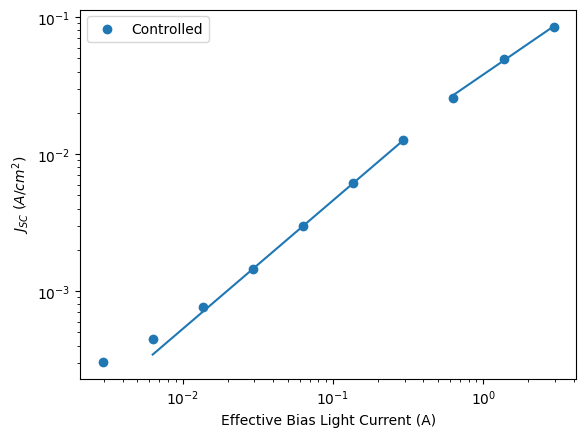

In [30]:
# plot actual Jsc values
plt.scatter(adjusted_bias_light_intensities_controlled,  Jscs_controlled,  label='Controlled'  )

# bias light values corresponding to the edges of the area to fit
left_edge_controlled  = 5e-3
right_edge_controlled = 6e-1
left_edge_uncontrolled  = 5e-3
right_edge_uncontrolled = 6e-1

# find the fits
params_jsc_controlled   = fit_bias_jsc(np.array(adjusted_bias_light_intensities_controlled  ),
                                       np.array(Jscs_controlled  ),
                                       left_edge_controlled,   right_edge_controlled,   'tab:blue'  )

# print out the parameters
print(f'Controlled:   A: {params_jsc_controlled[0]:.3e}, alpha: {params_jsc_controlled[1]:.3f}')

# bias light values corresponding to the edges of the area to fit
left_edge_controlled  = 4e-1
right_edge_controlled = 3e0

# find the fits
params_jsc_controlled2   = fit_bias_jsc(np.array(adjusted_bias_light_intensities_controlled  ),
                                        np.array(Jscs_controlled  ),
                                        left_edge_controlled,   right_edge_controlled,   'tab:blue'  )

# print out the parameters
print(f'Controlled2:   A: {params_jsc_controlled2[0]:.3e}, alpha: {params_jsc_controlled2[1]:.3f}')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Effective Bias Light Current (A)')
plt.ylabel('$J_{SC}$ $(A/cm^2)$')
plt.legend()
plt.show()

### $V_{OC}$ and Bias Light Intensity

$V_{OC}$ is fitted with the equation:
$$ V_{OC} = \frac{n_{id}k_B T}{q} \cdot \ln(\text{Bias}) + \frac{E_a}{q} $$

You will need to adjust the $V_{OC}$ values to fit the region you want. This is different for every sample.

Fitting Section 1 (going left to right)


ValueError: `ydata` must not be empty!

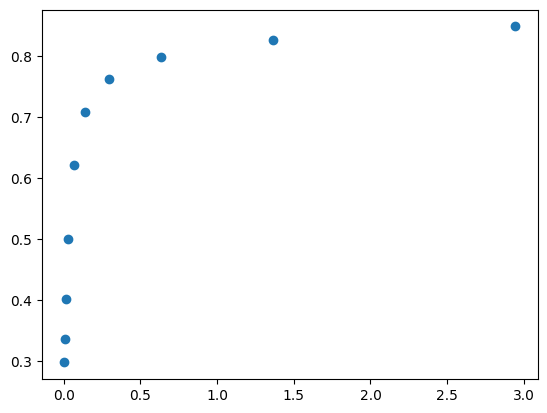

In [31]:
bias_controlled   = np.array(adjusted_bias_light_intensities_controlled)
vocs_controlled   = np.array(Vocs_controlled)

# use these lines to skip any points that are overlapping, replace `xx` and `yy` with the necessary indexes.
'''
bias_controlled   = np.array(adjusted_bias_light_intensities_controlled[:20]   + adjusted_bias_light_intensities_controlled[27:])
vocs_controlled   = np.array(Vocs_controlled[:20]   + Vocs_controlled[27:])
jscs_controlled   = np.array(Jscs_controlled[:20]   + Jscs_controlled[27:])
'''
# plot the actual data points
plt.scatter(bias_controlled,   vocs_controlled,  label='Controlled'  )


# fit section 1
print("Fitting Section 1 (going left to right)")
params_sec1_controlled,   nid1_light_controlled   = fit_bias_voc(bias_controlled,   vocs_controlled,   left_edge=1e-5, right_edge=1.5e-4, plot_color='tab:blue' )
print(f'Controlled:\n\t nid: {params_sec1_controlled[0]:.4f},\n\t E_a: {params_sec1_controlled[1]/q:.3f} eV')

# fit section 2
print("Fitting Section 2")
params_sec2_controlled,   nid2_light_controlled   = fit_bias_voc(bias_controlled,   vocs_controlled,   left_edge=1e-3, right_edge=5e-1, plot_color='tab:blue'  )
print(f'Controlled:\n\t nid: {params_sec2_controlled[0]:.4f},\n\t E_a: {params_sec2_controlled[1]/q:.3f} eV')

# fit section 3
print("Fitting Section 3")
params_sec3_controlled,   nid3_light_controlled   = fit_bias_voc(bias_controlled,   vocs_controlled,   left_edge=5e-1, right_edge=3e0, plot_color='tab:blue' )
print(f'Controlled:\n\t nid: {params_sec3_controlled[0]:.4f},\n\t E_a: {params_sec3_controlled[1]/q:.3f} eV')

plt.xscale('log')
plt.xlabel('Effective Bias Light Current (A)')
plt.ylabel('$V_{OC}$ (V)')
plt.legend()
plt.grid()
plt.show()

### $J_{SC}$, $V_{OC}$

Fits $J_{SC}$ as a function of $V_{OC}$ with the following equation:
$$ J_{SC} = J_0 \left(e^{\frac{q\cdot V_{OC}}{n_{id}\cdot k_B T}}-1\right) $$

When defining the fit region, use the $V_{OC}$ value for the left and right end points.

In [ ]:
jscs_controlled   = np.array(Jscs_controlled)
vocs_controlled   = np.array(Vocs_controlled) # these two need to be reset after removing points in the previous section.

# plot the actual points
plt.scatter(vocs_controlled,jscs_controlled,label='Controlled')

#plt.plot(estimated_voc_controlled,jscs_controlled,':',label='Isothermal, Controlled')
#plt.plot(estimated_voc_uncontrolled,jscs_uncontrolled,':',label='Isothermal, Uncontrolled')

left_edge_controlled  = 0.6 # V
right_edge_controlled = 0.8 # V

params_jscvoc_controlled = fit_jsc_voc(vocs_controlled,jscs_controlled, left_edge_controlled, right_edge_controlled, 'tab:blue')
print(f'Controlled:   n_id: {params_jscvoc_controlled[1]:.3f}, j0: {params_jscvoc_controlled[0]:.3e}')


plt.yscale('log')
plt.ylabel('$J_{SC}$ ($A/cm^2$)')
plt.xlabel('$V_{OC}$ (V)')
plt.xlim(np.min(vocs_controlled)-0.15,
         np.max(vocs_controlled)+0.05)
plt.legend()
plt.show()

#### Check Ratio of $\Delta V / V_{OC}$

This checks the accuracy of the TPV program's ability to control the $\Delta V / V_{OC}$ ratio.

You will need to adjust a couple of values in this block depending on the dataset.

In [ ]:
desired_ratio = 0.05 # 5%
tolerance     = 0.20 # 20%, this is a percentage of the desired ratio that defines the acceptable region
lower_limit   = desired_ratio - (desired_ratio * tolerance)
upper_limit   = desired_ratio + (desired_ratio * tolerance)

low_voc   = np.min(vocs_controlled) - 0.1
high_voc  = np.max(vocs_controlled) + 0.1
voc_range = np.linspace(low_voc, high_voc, 20)

# compute ratio
ratio_controlled   = [maxVoc/Voc for (maxVoc,Voc) in zip(Voc_maximums_controlled,  Vocs_controlled  )]

# Plot Ratio
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(12, 4))
ax1.scatter(adjusted_bias_light_intensities_controlled,ratio_controlled,label='Controlled')
ax2.scatter(Vocs_controlled,ratio_controlled,label='Controlled')

# desired ratio
ax1.hlines(y      = desired_ratio,
           xmin   = min(adjusted_bias_light_intensities_controlled),
           xmax   = max(adjusted_bias_light_intensities_controlled),
           colors = 'g', label = "5%")
ax2.hlines(y      = desired_ratio,
           xmin   = low_voc,
           xmax   = high_voc,
           colors = 'g', label = "5%")
# acceptable limits
ax1.hlines(y      = [lower_limit, upper_limit], 
           xmin   = min(adjusted_bias_light_intensities_controlled),
           xmax   = max(adjusted_bias_light_intensities_controlled),
           colors = ['gray', 'gray'])
ax2.hlines(y      = [lower_limit, upper_limit],
           xmin   = low_voc,
           xmax   = high_voc,
           colors = ['gray', 'gray'])

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Effective Bias Light Current (A)')
ax1.set_ylabel("$\Delta V/V_{OC}$")
ax1.legend()

ax2.set_yscale('log')
ax2.set_xlabel('$V_{OC}$ (V)')
ax2.set_ylabel("$\Delta V/V_{OC}$")
#ax2.set_xlim(0,0.9)             # this might need adjust for each dataset
ax2.legend()

ax3.scatter(Vocs_controlled, Voc_maximums_controlled, c=filters_controlled, cmap="coolwarm", zorder=3)
ax3.plot(voc_range, voc_range*desired_ratio, color='green', label="5%",        zorder=2)
ax3.plot(voc_range, voc_range*lower_limit,   color='gray',  label=r"$\pm$ 1%", zorder=2)
ax3.plot(voc_range, voc_range*upper_limit,   color='gray',                     zorder=2)

# these labels will need adjusted for each data set
ax3.text(0.4,  0.04, "ND2.5")
ax3.text(0.6, 0.05, "ND0.5")

ax3.set_ylabel('$\Delta V$ (V)')
ax3.set_xlabel("$V_{OC}$ (V)")
ax3.legend()
#ax3.set_xlim(0,0.95)
#ax3.set_ylim(0,0.07)
ax3.set_title("Ratio Controlled")

fig.suptitle("Controlling Ratio to ~5% \n"+ r"$\Delta V/V_{OC} = \frac{V_{max}-V_{OC}}{V_{OC}}$")
fig.tight_layout(rect=[0, 0, 1, 1.1])
plt.show()

### Capacitance
$$ C = Q / (V_{max} - V_{OC}) $$
$$ C = Ae^{k_1 V_{OC}} + Be^{k_2 V_{OC}} + c_0 $$
$$ C = Ae^{\frac{q \cdot V_{OC}}{m_1\cdot k_B T}} + Be^{\frac{q \cdot V_{OC}}{m_2\cdot k_B T}}$$



Adjust the $V_{OC}$ values included as needed to get a good fit.

In [ ]:

# Calculate Capacitance (units of F/cm^2)
Cs_controlled   = np.array([q/v for (q,v) in zip(Qs_controlled,  Voc_maximums_controlled  )])

# [ -np.inf,  -np.inf,  -np.inf,  -np.inf]
bounds_Cs_controlled   = ([ -np.inf,  15,  -np.inf,  0],# 5e-11], 
                          [ np.inf,  50,  np.inf,  10])#, 1e-7])

params_capacitance_controlled,   c0_controlled,   cap_fit_controlled   = fit_capacitance(np.array(Vocs_controlled),   Cs_controlled,   0.4, 0.85, 'tab:blue',
                                                                                         bounds = bounds_Cs_controlled)

Cu_cont = params_capacitance_controlled[2] * np.exp(params_capacitance_controlled[3]*np.insert(vocs_controlled,0,0))
# Print out the parameters
print(f'Controlled:   {params_capacitance_controlled}'  )

# grabs the geometric capacitance from the 1st point of the fit
c0_controlled   = cap_fit_controlled[0]
print(f'c0 (controlled):   {c0_controlled:.3e} F/cm^2')

# Scatter plot of actual data
plt.scatter(Vocs_controlled,  Cs_controlled,  label='Controlled'  )

vocs_controlled_0   = np.insert(vocs_controlled, 0,0)

# break the double exponential into two parts
def expCap(voc, A, m): return A*np.exp(q*voc/(m*kB*T))
cap_con_first_exp    = expCap(vocs_controlled_0,  params_capacitance_controlled[0],  params_capacitance_controlled[1])
cap_con_second_exp   = expCap(vocs_controlled_0,  params_capacitance_controlled[2],  params_capacitance_controlled[3])

plt.plot(vocs_controlled_0,   cap_con_first_exp,   ':',  label='1st Exp')
plt.plot(vocs_controlled_0,   cap_con_second_exp,  '-.', label='2nd Exp', color='tab:blue')

plt.xlabel('$V_{OC}$ (V)')
plt.ylabel('Capacitance ($F/cm^2$)')
plt.yscale('log')
plt.ylim(1e-9,2e-6)
#plt.xlim(0.7,0.9)
plt.legend()
plt.show()

### Charge Density, $n$

Fits charge density as function of $V_{OC}$ with the following formula:
$$ n = n_0 \cdot e^{\frac{q \cdot V_{OC}}{m\cdot k_B T}}$$

In [ ]:
vocs_controlled   = np.array(Vocs_controlled)

# chrage density from the raw data
n_controlled,   l1 = calculate_n(np.array(Cs_controlled  ), vocs_controlled  , "Raw Cap. Cont."  , 'tab:blue')

# find the charge density from the full fit of capacitance
n_from_full_fit_controlled,   l3 = calculate_n(cap_fit_controlled[5:],   vocs_controlled[4:],   "Full Cap. Fit Cont."  , 'tab:blue'  , 'line')

# find the charge density from just the exponential part of the fit
n_from_exp_fit_controlled,   l5 = calculate_n(cap_con_second_exp[5:],   vocs_controlled[4:],   "Right Exp. Fit Cont.",   'tab:blue',   '*')

n_from_exp_fit_controlled_left,   l7 = calculate_n(cap_con_first_exp[5:],   vocs_controlled[4:], "Left Exp. Fit Cont.",   'tab:blue',   '.')

n0_controlled,   m_controlled   = fit_voc_n(*data_selection(vocs_controlled[5:],  n_from_exp_fit_controlled,  0.7,0.8), 'black')

#n0_controlled2,   m_controlled2   = fit_voc_n(vocs_controlled,   n_from_exp_fit_controlled[19:-4],   'black')
#n0_uncontrolled2, m_uncontrolled2 = fit_voc_n(vocs_uncontrolled[20:-4], n_from_exp_fit_uncontrolled[19:-4], 'black')

print(f'Controlled:    \n\t m = {m_controlled:.3f},   \n\t n0 = {n0_controlled:.3e}')

plt.yscale('log')
plt.xlabel('$V_{OC}$ (V)')
plt.ylabel('Charge Density, $n$ ($cm^{-3}$)')
plt.ylim(1e13,3e17)
#plt.xlim(0.5,0.88)
plt.legend()
plt.grid()
plt.tick_params(which='both',right=True)
plt.show()

### TPV lifetimes and $V_{OC}$

Fits the lifetimes as a function of $V_{OC}$ with the following function:
$$ \tau = \tau_0 \cdot e^{\frac{-q\cdot V_{OC}}{\nu\cdot k_B T}} $$

If more fit sections are need, just call `fit_tau_voc`. If fewer fits are needed, comment out some of the function calls.

In [ ]:
plt.scatter(vocs_controlled,   tau1_TPV_controlled,   label=r'$\tau_1$ Controlled'  , color='tab:blue')
plt.scatter(vocs_controlled,   tau2_TPV_controlled,   label=r'$\tau_2$ Controlled'  , color='tab:blue',   marker='*')
plt.scatter(vocs_controlled,   tau3_TPV_controlled,   label=r'$\tau_3$ Controlled' , color='tab:blue',   marker='d')

# if you need to drop a point becuase of a bad fit,
# you can use the below code as the input for the fit_tau_voc function.
# This does not delete the point from the variable, it removes it just from the function input.
### np.delete(vocs_uncontrolled,[values]), np.delete(tau1_TPV_uncontrolled,[values])
### otherwise use vocs_uncontrolled, tau1_TPV_uncontrolled
params_tau1_TPV_controlled    = fit_tau_voc(vocs_controlled,   tau1_TPV_controlled,  0.7,0.8,'black')

nu_controlled    = params_tau1_TPV_controlled[1]

print(f'tau1, Controlled,   left part: \n\t nu: {params_tau1_TPV_controlled[1]:.3f},   \n\t tau0: {params_tau1_TPV_controlled[0]:.3e}')


tau_c_controlled   = nid2_light_controlled   * c0_controlled   * kB*T/(q*jscs_controlled)

plt.plot(vocs_controlled, tau_c_controlled,  '--', label=r'$\tau_c$ Controlled' ,  color='tab:blue')

plt.yscale('log')
plt.ylim(1e-7,1e-2)
#plt.xlim(0.8,1.25)
plt.xlabel(r'$V_{OC}$ (V)')
plt.ylabel(r'$\tau_{TPV}$ $(s)$')
#plt.legend()

# This vertical line represents the Voc value at which the Voc steeply falls away from a linear trend.
# It will have to be adjusted for each dataset.
#plt.vlines(x=0.9,ymin=1e-8,ymax=1e-3,colors='grey',linestyles=':')
#plt.vlines(x=1.2,ymin=1e-8,ymax=1e-3,colors='grey',linestyles=':')
#plt.grid()
plt.show()

### TPV lifetimes ($\tau_{TPV}$) and Charge Density ($n$)

Fits the lifetimes as a function of the charge density with the following function:
$$ \tau_{TPV} = \tau_0 \left( \frac{n}{n_0} \right)^{-m/\nu} $$
Ideality Factor:
$$ n_{id} = \left(\frac{1}{m} + \frac{1}{\nu}\right)^{-1} $$
Recombination Order:
$$ \delta = \frac{m}{\nu} +1 = \frac{m}{n_{id}}$$

In [ ]:
# plot the actual values
plt.scatter(n_from_exp_fit_controlled,   tau1_TPV_controlled[5:],   label=r'$\tau_1$ Controlled',   color='tab:blue'  )
plt.scatter(n_from_exp_fit_controlled,   tau2_TPV_controlled[5:],   label=r'$\tau_2$ Controlled',   color='tab:blue',   marker='*')
plt.scatter(n_from_exp_fit_controlled,   tau3_TPV_controlled[5:],   label=r'$\tau_3$ Controlled',   color='tab:blue',   marker='d')

# fit the data and plot the fit
tau0_controlled,    m_nu_controlled    = fit_tau_n(n_from_exp_fit_controlled,     tau1_TPV_controlled[5:],   n0_controlled, 5e13, 1.2e15, 'black')

print(f'Controlled,   left part: \n\t lambda = {   m_nu_controlled:.3f},\n\t tau0 = {   tau0_controlled:.3e}')


#nu_controlled = m_controlled / m_nu_controlled
#m_controlled = nu_controlled * m_nu_controlled

plt.plot(n_from_exp_fit_controlled, tau_c_controlled[5:], '--', label=r'$\tau_c$ Controlled', color='tab:blue')

plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\tau_{TPV}$ $(s)$')
plt.xlabel('Charge Density, $n$ ($cm^{-3}$)')
#plt.legend()
#plt.xlim(1e13,1e17)
plt.ylim(1e-7,1e-2)
plt.grid()
plt.show()

n_id_controlled = ((1/m_controlled) + (1/nu_controlled))**(-1)

print(f'Controlled,   left  part:\n\t n_id = {n_id_controlled:.3f},'+
                            f'\n\t m    = {m_controlled:.3f},'   +
                            f'\n\t nu   = {nu_controlled:.3f}'   +
                            f'\n\t m/nu = {m_controlled/nu_controlled:.3f},')

recomb_controlled    = m_controlled    / n_id_controlled

print(f'Controlled,   left  part: recomb = {recomb_controlled:.3f}'   )
